In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures
from category_encoders import BinaryEncoder, OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metric
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, make_scorer, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

from scipy.stats import kruskal, mannwhitneyu

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier # bagging
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier # boosting
from xgboost import XGBClassifier #xgboost

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

# Background


Deposit is one of financial products among many others. This product is very popular due to clear returns and easy to understand process. But due to many competitors, limited resources and time constraint,  this product need to identify potential customers to stay ahead of competitors. Identifying potential customers help in allocating resources and avoid any missed opportunity.

# Problem Statement

- How can we leverage Machine Learning to identify potential customers 

# Confusion Matrix

- True Positive: Predicted to deposit and actually deposit

- False Positive: predicted to deposit and actually not deposit

- True Negative: predicted to not deposit and actually not deposit

- False Negative: predicted to not deposit and actually deposit


from this breakdown, we can identify **False Negative is more costly** because it would mean unfulfilled revenue. <br>
While false positive is less costly because operational cost is not much different and also part of sales job.

But when prioritizing recall in developing model, the number of false positive equals to true positive. The model identifies customers as deposit to minimize false negative and resulted in 1:1 ratio. This is not a helpful model because it has the same possibility of randomly contacting customers from database (47% customers deposit from entire database).<br>

instead, we are going to use **precision**, because reducing false positive would lead to higher model trustworthiness (model predict deposit customer more accuratte). We want the model to predict positive class with high accuracy so those predicted to deposit will be prioritized to be contacted. The result would be a faster conversion and customers goal earlier. 

# Data

In [2]:
df = pd.read_csv('C:/Users/yyogi/OneDrive/Data Science Purwadhika/Catatan Modul 3 Machine Learning/Capstone Project Model 3/data_bank_marketing_campaign.csv')

df['deposit'] = np.where(df['deposit']=='yes',1,0)

df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,1
2,51,admin.,3025,no,no,cellular,may,1,352,other,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,0


## Feature explaination

**Customer Profile:**
- age
- job
- balance
- housing
- loan

**Marketing Data:**
- Contact (contact communication type)

- month (The month customer was contacted in)

- campaign (Number of contacts performed during this campaign and for this client)

- pdays (Number of days after the client was contacted from the previous campaign)

- poutcome (Outcome of the previous marketing campaign)

- deposit (Whether the customers deposit or not)

There are 8 duplicated data. We are going to drop these rows because it would affect results if it had not.

In [3]:
df.duplicated().sum()


8

In [4]:
df = df.drop_duplicates()

There are no missing values

In [5]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

Data is evenly distributed. Imbalance method is not required

In [6]:
df['deposit'].value_counts() /len(df)*100

0    52.210122
1    47.789878
Name: deposit, dtype: float64

Checking all values in features

In [7]:
pd.set_option('display.max_colwidth', -1)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,age,75,"[55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]"
1,job,12,"[admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown]"
2,balance,3153,"[1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]"
3,housing,2,"[no, yes]"
4,loan,2,"[no, yes]"
5,contact,3,"[cellular, telephone, unknown]"
6,month,12,"[jun, apr, may, nov, jan, sep, feb, mar, aug, jul, oct, dec]"
7,campaign,32,"[2, 3, 1, 4, 5, 6, 7, 30, 8, 9, 11, 14, 10, 28, 63, 12, 24, 17, 15, 18, 19, 13, 21, 23, 22, 33, 16, 25, 26, 20, 29, 43]"
8,pdays,422,"[-1, 352, 21, 91, 186, 263, 96, 355, 294, 412, 89, 114, 276, 93, 175, 57, 323, 156, 86, 95, 271, 182, 289, 334, 269, 309, 144, 183, 417, 138, 254, 337, 171, 389, 87, 170, 165, 372, 247, 98, 196, 469, 272, 104, 63, 587, 336, 145, 130, 28, 202, 324, 147, 94, 328, 420, 179, 90, 81, 160, 298, 356, 357, 267, 430, 52, 181, 365, 237, 330, 103, 374, 75, 133, 321, 204, 782, 266, 197, 270, 318, 349, 187, 359, 490, 192, 227, 100, 168, 177, 251, 301, 350, 92, 184, 345, 290, 199, 333, 169, ...]"
9,poutcome,4,"[unknown, other, failure, success]"


poutcome is the outcome of previous marketing campaign.<br>

We are going to replace the unknown value with failure since never hearding back can be regarded as failure

In [8]:
df['poutcome'].value_counts()

unknown    5811
failure    848 
success    761 
other      385 
Name: poutcome, dtype: int64

In [9]:
df['poutcome'] = df['poutcome'].replace('unknown',np.nan)

In [10]:
imp_mode = SimpleImputer(strategy='constant',fill_value='failure')

df[['poutcome']] = imp_mode.fit_transform(df[['poutcome']])
df

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,failure,1
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,failure,1
2,51,admin.,3025,no,no,cellular,may,1,352,other,1
3,38,services,-87,yes,no,cellular,may,1,-1,failure,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,failure,0
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,failure,1
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,1
7810,36,unknown,179,no,no,cellular,aug,8,-1,failure,0
7811,31,admin.,54,yes,no,cellular,nov,1,-1,failure,0


### Binning process for age

to categorize age

- 18-30 --> young
- 31-57 --> Middle age
- 58> --> retiree   (as stated in indonesian law )

we assume age has effect on their intention to deposit.


In [11]:
list_age = []
for i in df['age']:
    if 18<=i<=30:
        list_age.append('young')
    elif 31<=i<=57:
        list_age.append('productive age')
    else:
        list_age.append('retiree')

In [12]:
df['bin_age'] = list_age


In [13]:
df = df.drop(columns='age')

<AxesSubplot:title={'center':'Age vs Deposit'}, xlabel='bin_age', ylabel='count'>

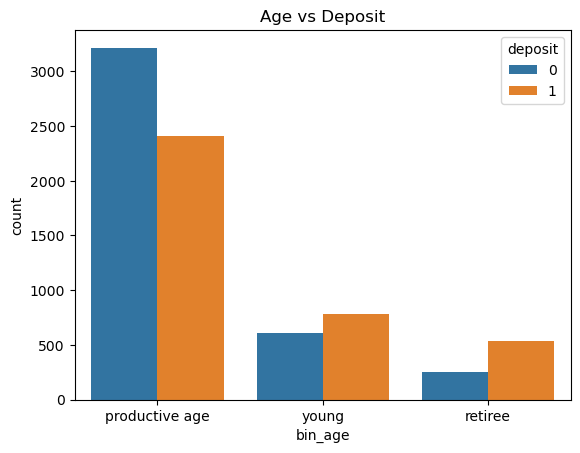

In [14]:
plt.title('Age vs Deposit')

sns.countplot(data=df,x='bin_age',hue='deposit')

### Multicollinearity Check

to check correlatedness of features. Some methods requires independent features such as naive bayes

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

In [16]:
def calc_vif(X):

    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, kolom) for kolom in range(len(X.columns))]

    return vif

In [17]:
X = df.drop(columns='deposit')

X = sm.add_constant(X)

X.head()


,const,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,bin_age
0,1.0,admin.,1662,no,no,cellular,jun,2,-1,failure,productive age
1,1.0,self-employed,-3058,yes,yes,cellular,apr,3,-1,failure,productive age
2,1.0,admin.,3025,no,no,cellular,may,1,352,other,productive age
3,1.0,services,-87,yes,no,cellular,may,1,-1,failure,productive age
4,1.0,housemaid,205,yes,no,telephone,nov,4,-1,failure,productive age


In [18]:
X = pd.get_dummies(data=X, drop_first=True)

In [19]:
calc_vif(X.drop(columns=['const'])).sort_values(by='VIF',ascending=False)

,feature,VIF
25,month_may,3.355168
14,housing_yes,2.465946
17,contact_unknown,2.382465
6,job_management,2.231419
23,month_jun,2.098794
7,job_retired,2.073393
3,job_blue-collar,1.966147
1,campaign,1.962602
18,month_aug,1.917717
11,job_technician,1.912159


There are no multicollinearity because VIF factors are low

## Preprocessing

Robust scaler: balance, campaign, pdays

onehot: job, housing, loan, contact, month, poutcome, bin_age

In [20]:
transformer = ColumnTransformer([
    ('robust',RobustScaler(),['balance','campaign','pdays']),
    ('onehot',OneHotEncoder(drop='first'),['job','housing','loan','contact','month','poutcome','bin_age'])
],remainder='passthrough')
    
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('robust', RobustScaler(),
                                 ['balance', 'campaign', 'pdays']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['job', 'housing', 'loan', 'contact', 'month',
                                  'poutcome', 'bin_age'])])

### Train test split

In [21]:
X = df.drop(columns='deposit')

y = df['deposit']

In [22]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

### f2 score

In [23]:
f2_scorer = make_scorer(fbeta_score, beta=2)

f2_scorer

make_scorer(fbeta_score, beta=2)

## Feature Selection

To check feature strength of predicting y label. We are going to use forward feature selection

In [24]:
rf = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
xgboost = XGBClassifier(random_state=0)

logreg = LogisticRegression(random_state=0,solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

naive_bayes = GaussianNB()
svm_ = svm.SVC(random_state=0)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier # bagging

from sklearn.model_selection import cross_validate
from mlxtend.preprocessing import DenseTransformer


In [25]:
sfs = SFS(naive_bayes,
          k_features=19,
          forward=True,
          floating=False,
          scoring='precision',
          cv=5,
          n_jobs=-1)

pipe_model = Pipeline([
            ('transformer',transformer),
            ('dense',DenseTransformer()),
            ('feature_selection',sfs)])

pipe_model.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust', RobustScaler(),
                                                  ['balance', 'campaign',
                                                   'pdays']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'housing', 'loan',
                                                   'contact', 'month',
                                                   'poutcome', 'bin_age'])])),
                ('dense', DenseTransformer()),
                ('feature_selection',
                 SequentialFeatureSelector(estimator=GaussianNB(),
                                           k_features=(19, 19), n_jobs=-1,
                                           scoring='precision'))])

In [26]:
pd.DataFrame(sfs.subsets_)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
feature_idx,"(30,)","(1, 30)","(1, 3, 30)","(1, 3, 4, 30)","(1, 3, 4, 8, 30)","(1, 3, 4, 8, 11, 30)","(1, 3, 4, 8, 11, 18, 30)","(1, 3, 4, 8, 11, 18, 24, 30)","(1, 3, 4, 5, 8, 11, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 11, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 15, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 15, 18, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 15, 18, 19, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 21, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 21, 22, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 21, 22, 23, 24, 26, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30)"
cv_scores,"[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.8888888888888888, 0.8925619834710744, 0.9083333333333333, 0.967741935483871, 0.8947368421052632]","[0.888235294117647, 0.8758169934640523, 0.9044117647058824, 0.9594594594594594, 0.8920863309352518]","[0.888235294117647, 0.8758169934640523, 0.9044117647058824, 0.9594594594594594, 0.8920863309352518]","[0.888235294117647, 0.8758169934640523, 0.9044117647058824, 0.9594594594594594, 0.8920863309352518]","[0.888235294117647, 0.8758169934640523, 0.9044117647058824, 0.9594594594594594, 0.8920863309352518]","[0.888235294117647, 0.8758169934640523, 0.9044117647058824, 0.9594594594594594, 0.8920863309352518]","[0.888235294117647, 0.8758169934640523, 0.9044117647058824, 0.9594594594594594, 0.8920863309352518]","[0.8863636363636364, 0.8719512195121951, 0.8972602739726028, 0.9605263157894737, 0.8775510204081632]","[0.8863636363636364, 0.8719512195121951, 0.8972602739726028, 0.9605263157894737, 0.8775510204081632]","[0.8863636363636364, 0.8719512195121951, 0.8972602739726028, 0.9605263157894737, 0.8775510204081632]","[0.8863636363636364, 0.8719512195121951, 0.8972602739726028, 0.9605263157894737, 0.8775510204081632]","[0.8863636363636364, 0.8719512195121951, 0.8972602739726028, 0.9605263157894737, 0.8775510204081632]","[0.8863636363636364, 0.8719512195121951, 0.8807947019867549, 0.9325153374233128, 0.8775510204081632]"
avg_score,0.910453,0.910453,0.910453,0.910453,0.910453,0.910453,0.910453,0.904002,0.904002,0.904002,0.904002,0.904002,0.904002,0.89873,0.89873,0.89873,0.89873,0.89873,0.889835
feature_names,"(30,)","(1, 30)","(1, 3, 30)","(1, 3, 4, 30)","(1, 3, 4, 8, 30)","(1, 3, 4, 8, 11, 30)","(1, 3, 4, 8, 11, 18, 30)","(1, 3, 4, 8, 11, 18, 24, 30)","(1, 3, 4, 5, 8, 11, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 11, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 15, 18, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 15, 18, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 15, 18, 19, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 21, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 21, 22, 23, 24, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 18, 19, 21, 22, 23, 24, 26, 30)","(1, 3, 4, 5, 6, 8, 9, 11, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 30)"


In [27]:
onehot_columns = pipe_model.named_steps['transformer'].named_transformers_['onehot'].get_feature_names()
numerical_columns = pipe_model.named_steps['transformer'].named_transformers_['robust'].get_feature_names_out()

feature_names = np.concatenate((numerical_columns,onehot_columns))

len(feature_names)

33

In [28]:
pd.DataFrame({
    'number':list(range(len(feature_names))),
    'feature': feature_names
})

,number,feature
0,0,balance
1,1,campaign
2,2,pdays
3,3,x0_blue-collar
4,4,x0_entrepreneur
5,5,x0_housemaid
6,6,x0_management
7,7,x0_retired
8,8,x0_self-employed
9,9,x0_services


Using precision as scoring goal, we found that the best score is to use 7 features:
(1, 3, 4, 8, 11, 18, 30)	
- campaign
- x0_blue-collar
- x0_entrepreneur
- x0_self-employed
- x0_technician
- x4_aug
- x5_success

But this would defeat the purpose of learning and inflating the false positive.

Hence, we are going to use accuracy for feature selection only as we want to keep data pure.

In [29]:
sfs = SFS(naive_bayes,
          k_features=19,
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5,
          n_jobs=-1)

pipe_model = Pipeline([
            ('transformer',transformer),
            ('dense', DenseTransformer()),
            ('feature_selection',sfs)])

pipe_model.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust', RobustScaler(),
                                                  ['balance', 'campaign',
                                                   'pdays']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['job', 'housing', 'loan',
                                                   'contact', 'month',
                                                   'poutcome', 'bin_age'])])),
                ('dense', DenseTransformer()),
                ('feature_selection',
                 SequentialFeatureSelector(estimator=GaussianNB(),
                                           k_features=(19, 19), n_jobs=-1,
                                           scoring='accuracy'))])

In [30]:
df_sfs_acc = pd.DataFrame(sfs.subsets_)
df_sfs_acc

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
feature_idx,"(14,)","(14, 15)","(14, 15, 17)","(14, 15, 17, 27)","(14, 15, 17, 21, 27)","(4, 14, 15, 17, 21, 27)","(0, 4, 14, 15, 17, 21, 27)","(0, 4, 11, 14, 15, 17, 21, 27)","(0, 4, 11, 14, 15, 17, 18, 21, 27)","(0, 2, 4, 11, 14, 15, 17, 18, 21, 27)","(0, 2, 4, 11, 14, 15, 17, 18, 21, 22, 27)","(0, 2, 4, 11, 14, 15, 17, 18, 21, 22, 27, 32)","(0, 2, 4, 11, 14, 15, 16, 17, 18, 21, 22, 27, 32)","(0, 2, 4, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 32)","(0, 2, 4, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 32)","(0, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 32)","(0, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 29, 32)","(0, 1, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 29, 32)","(0, 1, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 29, 31, 32)"
cv_scores,"[0.6108887109687751, 0.6301040832666133, 0.6052842273819056, 0.5820656525220176, 0.5969551282051282]","[0.6269015212169736, 0.6501200960768615, 0.6132906325060048, 0.6068855084067254, 0.6097756410256411]","[0.6108887109687751, 0.6685348278622898, 0.6068855084067254, 0.6244995996797438, 0.6113782051282052]","[0.6517213771016813, 0.6901521216973578, 0.6501200960768615, 0.6429143314651722, 0.6450320512820513]","[0.6509207365892714, 0.6909527622097679, 0.6581265012009607, 0.6405124099279423, 0.6426282051282052]","[0.6509207365892714, 0.6901521216973578, 0.6565252201761409, 0.6397117694155324, 0.6466346153846154]","[0.6493194555644516, 0.6901521216973578, 0.6501200960768615, 0.6405124099279423, 0.6578525641025641]","[0.6509207365892714, 0.6901521216973578, 0.6469175340272217, 0.6397117694155324, 0.655448717948718]","[0.6493194555644516, 0.6901521216973578, 0.6477181745396317, 0.6397117694155324, 0.65625]","[0.6405124099279423, 0.7037630104083267, 0.655724579663731, 0.6381104883907126, 0.6602564102564102]","[0.6525220176140912, 0.6917534027221778, 0.6677341873498799, 0.655724579663731, 0.6506410256410257]","[0.6477181745396317, 0.7069655724579663, 0.6589271417133707, 0.6653322658126501, 0.6618589743589743]","[0.644515612489992, 0.7061649319455564, 0.6597277822257807, 0.6637309847878302, 0.6626602564102564]","[0.6485188150520417, 0.6941553242594075, 0.655724579663731, 0.6709367493995196, 0.6722756410256411]","[0.6501200960768615, 0.6941553242594075, 0.6565252201761409, 0.6701361088871097, 0.6626602564102564]","[0.6549239391513211, 0.6973578863090473, 0.66693354683747, 0.6613290632506005, 0.6426282051282052]","[0.6517213771016813, 0.6893514811849479, 0.6549239391513211, 0.6701361088871097, 0.6602564102564102]","[0.655724579663731, 0.6957566052842273, 0.6533226581265013, 0.6645316253002402, 0.6538461538461539]","[0.6661329063250601, 0.7085668534827863, 0.6645316253002402, 0.6717373899119295, 0.6618589743589743]"
avg_score,0.60506,0.621395,0.624437,0.655988,0.656628,0.656789,0.657591,0.65663,0.65663,0.659673,0.663675,0.66816,0.66736,0.668322,0.666719,0.664635,0.665278,0.664636,0.674566
feature_names,"(14,)","(14, 15)","(14, 15, 17)","(14, 15, 17, 27)","(14, 15, 17, 21, 27)","(4, 14, 15, 17, 21, 27)","(0, 4, 14, 15, 17, 21, 27)","(0, 4, 11, 14, 15, 17, 21, 27)","(0, 4, 11, 14, 15, 17, 18, 21, 27)","(0, 2, 4, 11, 14, 15, 17, 18, 21, 27)","(0, 2, 4, 11, 14, 15, 17, 18, 21, 22, 27)","(0, 2, 4, 11, 14, 15, 17, 18, 21, 22, 27, 32)","(0, 2, 4, 11, 14, 15, 16, 17, 18, 21, 22, 27, 32)","(0, 2, 4, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 32)","(0, 2, 4, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 32)","(0, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 32)","(0, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 29, 32)","(0, 1, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 29, 32)","(0, 1, 2, 4, 5, 8, 11, 14, 15, 16, 17, 18, 21, 22, 26, 27, 29, 31, 32)"


In [31]:
df_sfs_acc.iloc[3].reset_index()

,index,feature_names
0,1,"(14,)"
1,2,"(14, 15)"
2,3,"(14, 15, 17)"
3,4,"(14, 15, 17, 27)"
4,5,"(14, 15, 17, 21, 27)"
5,6,"(4, 14, 15, 17, 21, 27)"
6,7,"(0, 4, 14, 15, 17, 21, 27)"
7,8,"(0, 4, 11, 14, 15, 17, 21, 27)"
8,9,"(0, 4, 11, 14, 15, 17, 18, 21, 27)"
9,10,"(0, 2, 4, 11, 14, 15, 17, 18, 21, 27)"


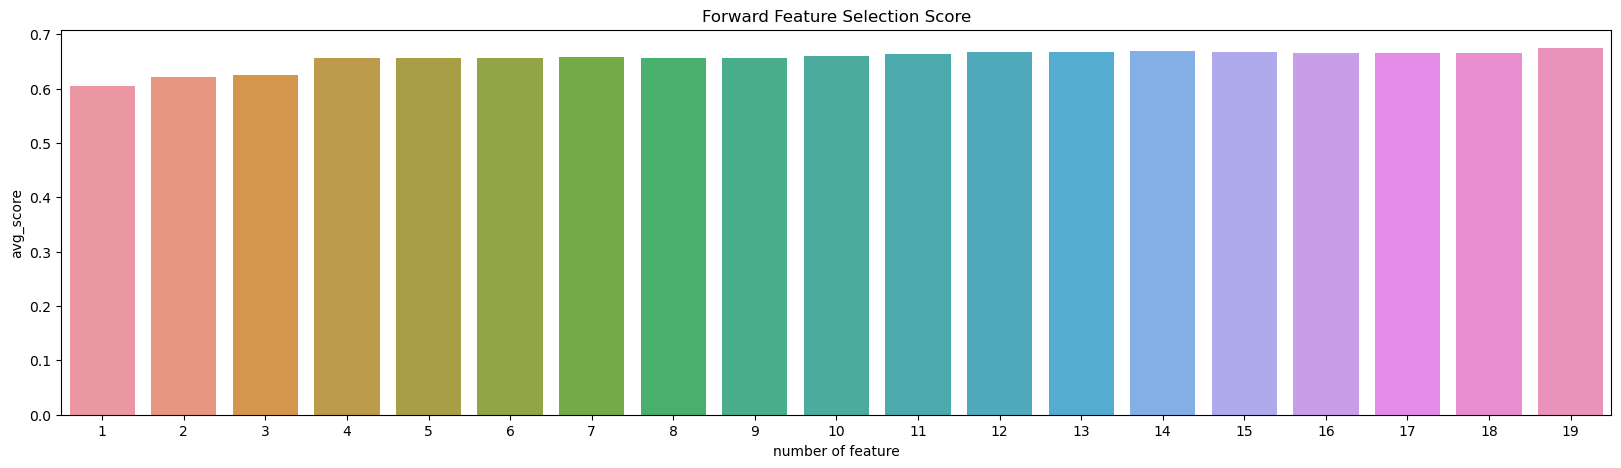

In [32]:

plt.figure(figsize=(20,5))
plt.title('Forward Feature Selection Score')
sns.barplot(data=df_sfs_acc.T,x='feature_names',y='avg_score')
plt.xticks(ticks= list(range(19)),labels= list(df_sfs_acc.iloc[3].reset_index()['index']))
plt.xlabel('number of feature');

as shown in the result, the best outcome is to use all of features as data point

## Polynomial

On this step, we would like to handle underfitting. We assume 10 variables may not be able to accurately predict deposit or not.

In [33]:
list_model = [logreg, knn,tree, rf, adaboost, gboost,xgboost,naive_bayes,svm_]
list_nama_model = []
list_degrees = []
list_all_poly = []

n_degrees = range(1,4)

scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'f1': 'f1',
           'f2':f2_scorer,
           'precision':'precision'}

for i in n_degrees:
    pipe_numerical = Pipeline([
    ('poly',PolynomialFeatures(degree=i)),
    ('scaler',RobustScaler())])

    transformer_poly = ColumnTransformer([
    ('poly',pipe_numerical,['balance','campaign','pdays']),
    ('onehot',OneHotEncoder(drop='first'),['job','housing','loan','contact','month','poutcome','bin_age'])
],remainder='passthrough')
    

    for model in list_model:
        pipe_poly = Pipeline([
            ('transformer',transformer_poly),
            ('dense',DenseTransformer()),
            ('model',model),
        ])
        

        model_cv_poly = cross_validate(
            estimator= pipe_poly,
            X= X_train,
            y= y_train,
            scoring=scoring,
            cv= 5,
            error_score='raise'
        )

        list_all_poly.append(model_cv_poly)
        list_nama_model.append(model)
        list_degrees.append(i)

In [34]:
result_cross_val = pd.DataFrame({
    'model':list_nama_model,
    'degree': list_degrees,
    'recall': [list_all_poly[i]['test_recall'].mean() for i in range(len(list_all_poly))],
    'recall_std': [list_all_poly[i]['test_recall'].std() for i in range(len(list_all_poly))],
    'acc': [list_all_poly[i]['test_acc'].mean() for i in range(len(list_all_poly))],
    'acc_std': [list_all_poly[i]['test_acc'].std() for i in range(len(list_all_poly))],
    'f1': [list_all_poly[i]['test_f1'].mean() for i in range(len(list_all_poly))],
    'f1_std': [list_all_poly[i]['test_f1'].std() for i in range(len(list_all_poly))],
    'f2': [list_all_poly[i]['test_f2'].mean() for i in range(len(list_all_poly))],
    'f2_std': [list_all_poly[i]['test_f2'].std() for i in range(len(list_all_poly))],
    'precision': [list_all_poly[i]['test_precision'].mean() for i in range(len(list_all_poly))],
    'precision_std': [list_all_poly[i]['test_precision'].std() for i in range(len(list_all_poly))]

})

result_cross_val.sort_values('precision',ascending=False)

,model,degree,recall,recall_std,acc,acc_std,f1,f1_std,f2,f2_std,precision,precision_std
7,GaussianNB(),1,0.449398,0.016727,0.670564,0.011689,0.565848,0.017044,0.489695,0.016897,0.764247,0.020659
8,SVC(random_state=0),1,0.589469,0.018851,0.714124,0.021687,0.663518,0.023195,0.616988,0.020102,0.759220,0.033235
23,GradientBoostingClassifier(random_state=0),3,0.603876,0.017443,0.717968,0.011780,0.671708,0.013920,0.629254,0.015647,0.757323,0.020219
5,GradientBoostingClassifier(random_state=0),1,0.611919,0.022355,0.718288,0.015558,0.674821,0.018879,0.635575,0.020710,0.752733,0.022089
14,GradientBoostingClassifier(random_state=0),2,0.611590,0.014260,0.717168,0.014468,0.673989,0.014576,0.635070,0.013499,0.751100,0.024671
9,"LogisticRegression(random_state=0, solver='liblinear')",2,0.605221,0.019051,0.713965,0.018989,0.669175,0.020940,0.629258,0.019459,0.748522,0.027238
0,"LogisticRegression(random_state=0, solver='liblinear')",1,0.598854,0.019879,0.711082,0.016522,0.664514,0.019619,0.623482,0.019631,0.746563,0.022105
4,AdaBoostClassifier(random_state=0),1,0.604883,0.019033,0.712361,0.019554,0.667878,0.019725,0.628534,0.018255,0.746428,0.032888
13,AdaBoostClassifier(random_state=0),2,0.606559,0.019440,0.709320,0.013117,0.665985,0.015500,0.628964,0.017469,0.738930,0.020491
22,AdaBoostClassifier(random_state=0),3,0.608236,0.016219,0.705636,0.014636,0.663899,0.014698,0.629290,0.014678,0.731458,0.025070


## Cross Validation

In [35]:


# Define models (3 kandidat model)
logreg = LogisticRegression(random_state=0,solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)
# pilihan model algoritma
models = [logreg, knn, tree, rf, adaboost, gboost,xgboost,svm_,naive_bayes]
list_hasil = []
list_model_kosong = []

scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'f1': 'f1',
           'f2':f2_scorer,
           'precision':'precision'}

for i in models:

    pipe_model = Pipeline([
                        ('preprocess', transformer),
                        ('dense',DenseTransformer()),
                        ('model', i)
                    ])
    skfold = StratifiedKFold(n_splits=5)
    # cross val
    model_cv = cross_validate(
        estimator = pipe_model, 
        X = X_train, 
        y = y_train, 
        cv = skfold,
        scoring = scoring,
        error_score = 'raise',
        )

    list_hasil.append(model_cv)
    list_model_kosong.append(i)

list_hasil

[{'fit_time': array([0.01832628, 0.02403831, 0.02068448, 0.01989555, 0.0211935 ]),
  'score_time': array([0.01846409, 0.00865698, 0.00825739, 0.00888515, 0.00802946]),
  'test_acc': array([0.70616493, 0.73098479, 0.68454764, 0.72618094, 0.70753205]),
  'test_recall': array([0.60469012, 0.61474037, 0.57118928, 0.62311558, 0.58053691]),
  'test_f1': array([0.66299357, 0.68598131, 0.633829  , 0.68508287, 0.65468307]),
  'test_f2': array([0.62673611, 0.64138413, 0.59469829, 0.64650678, 0.60808436]),
  'test_precision': array([0.73373984, 0.77589852, 0.71189979, 0.7607362 , 0.7505423 ])},
 {'fit_time': array([0.01309109, 0.01726913, 0.02252769, 0.02331805, 0.01771808]),
  'score_time': array([0.13970971, 0.13264036, 0.13570571, 0.14138794, 0.14104629]),
  'test_acc': array([0.66773419, 0.68935148, 0.66693355, 0.68134508, 0.67708333]),
  'test_recall': array([0.61306533, 0.639866  , 0.60636516, 0.59798995, 0.58724832]),
  'test_f1': array([0.63818657, 0.66319444, 0.63508772, 0.64208633, 0.63

In [36]:
# Perbandingan performa antar model
result_cross_val_2 = pd.DataFrame({
    'model':list_model_kosong,
    'recall': [list_hasil[i]['test_recall'].mean() for i in range(len(list_hasil))],
    'recall_std': [list_hasil[i]['test_recall'].std() for i in range(len(list_hasil))],
    'acc': [list_hasil[i]['test_acc'].mean() for i in range(len(list_hasil))],
    'acc_std': [list_hasil[i]['test_acc'].std() for i in range(len(list_hasil))],
    'f1': [list_hasil[i]['test_f1'].mean() for i in range(len(list_hasil))],
    'f1_std': [list_hasil[i]['test_f1'].std() for i in range(len(list_hasil))],
    'f2': [list_hasil[i]['test_f2'].mean() for i in range(len(list_hasil))],
    'f2_std': [list_hasil[i]['test_f2'].std() for i in range(len(list_hasil))],
    'precision': [list_hasil[i]['test_precision'].mean() for i in range(len(list_hasil))],
    'precision_std': [list_hasil[i]['test_precision'].std() for i in range(len(list_hasil))]

})
    
result_cross_val = pd.concat([result_cross_val,result_cross_val_2]).reset_index(drop=True).sort_values('precision',ascending=False)

result_cross_val

,model,degree,recall,recall_std,acc,acc_std,f1,f1_std,f2,f2_std,precision,precision_std
35,GaussianNB(),NaN,0.449398,0.016727,0.670564,0.011689,0.565848,0.017044,0.489695,0.016897,0.764247,0.020659
7,GaussianNB(),1.0,0.449398,0.016727,0.670564,0.011689,0.565848,0.017044,0.489695,0.016897,0.764247,0.020659
34,SVC(random_state=0),NaN,0.589469,0.018851,0.714284,0.021623,0.663643,0.023103,0.617030,0.020054,0.759561,0.033216
8,SVC(random_state=0),1.0,0.589469,0.018851,0.714124,0.021687,0.663518,0.023195,0.616988,0.020102,0.759220,0.033235
23,GradientBoostingClassifier(random_state=0),3.0,0.603876,0.017443,0.717968,0.011780,0.671708,0.013920,0.629254,0.015647,0.757323,0.020219
32,GradientBoostingClassifier(random_state=0),NaN,0.612254,0.022755,0.718448,0.015830,0.675060,0.019263,0.635877,0.021119,0.752821,0.022227
5,GradientBoostingClassifier(random_state=0),1.0,0.611919,0.022355,0.718288,0.015558,0.674821,0.018879,0.635575,0.020710,0.752733,0.022089
14,GradientBoostingClassifier(random_state=0),2.0,0.611590,0.014260,0.717168,0.014468,0.673989,0.014576,0.635070,0.013499,0.751100,0.024671
9,"LogisticRegression(random_state=0, solver='liblinear')",2.0,0.605221,0.019051,0.713965,0.018989,0.669175,0.020940,0.629258,0.019459,0.748522,0.027238
27,"LogisticRegression(random_state=0, solver='liblinear')",NaN,0.598854,0.019879,0.711082,0.016522,0.664514,0.019619,0.623482,0.019631,0.746563,0.022105


### Ensemble Method

Voting

In [37]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [38]:

# Voting (ensemble)
voting_clf = VotingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

pipe_model = Pipeline([
    ('transformer', transformer),
    ('dense',DenseTransformer()),
    ('model', voting_clf)
])

scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'f1': 'f1',
           'f2':f2_scorer,
           'precision':'precision'}

# cross validation
voting_cv = cross_validate(
    estimator= pipe_model,
    X= X_train,
    y= y_train,
    cv= 5,
    scoring= scoring
)

voting_cv

{'fit_time': array([0.03092265, 0.03525138, 0.03237391, 0.03003645, 0.03543162]),
 'score_time': array([0.14929008, 0.14787984, 0.14476752, 0.13635135, 0.13986111]),
 'test_acc': array([0.71016813, 0.73819055, 0.69015212, 0.72778223, 0.70753205]),
 'test_recall': array([0.60971524, 0.61139028, 0.55778894, 0.59128978, 0.55201342]),
 'test_f1': array([0.66788991, 0.69063387, 0.63247863, 0.6749522 , 0.64320626]),
 'test_f2': array([0.6317251 , 0.64080056, 0.58544304, 0.62213606, 0.585201  ]),
 'test_precision': array([0.73833671, 0.79347826, 0.73026316, 0.78619154, 0.7704918 ])}

In [39]:
df_voting = pd.DataFrame({
    'model':'voting',
    'degree': np.nan,
    'recall': [voting_cv['test_recall'].mean()],
    'recall_std':[voting_cv['test_recall'].std()],
    'acc': [voting_cv['test_acc'].mean()],
    'acc_std':[voting_cv['test_acc'].std()],
    'f1': [voting_cv['test_f1'].mean()],
    'f1_std':[voting_cv['test_f1'].std()],
    'f2': [voting_cv['test_f2'].mean()],
    'f2_std': [voting_cv['test_f2'].std()],
    'precision': [voting_cv['test_precision'].mean()],
    'precision_std': [voting_cv['test_precision'].std()]
})

result_cross_val = pd.concat([result_cross_val,df_voting]).reset_index(drop=True).sort_values('recall',ascending=False)

Stacking

In [40]:
# stacking (ensemble)
stacking_clf = StackingClassifier([
    ('clf1', logreg),
    ('clf2', knn),
    ('clf3', tree)
])

pipe_model = Pipeline([
    ('scaler', transformer),
    ('dense',DenseTransformer()),
    ('model', stacking_clf)
])

scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'f1': 'f1',
           'f2':f2_scorer,
           'precision':'precision'}
# cross validation
stacking_cv = cross_validate(
    estimator= pipe_model,
    X= X_train,
    y= y_train,
    cv= 5,
    scoring= scoring
)

stacking_cv

{'fit_time': array([0.49441504, 0.46956587, 0.45403194, 0.46336365, 0.46307397]),
 'score_time': array([0.12943149, 0.10903287, 0.11260772, 0.11105061, 0.12754846]),
 'test_acc': array([0.70696557, 0.74139311, 0.68694956, 0.72297838, 0.71314103]),
 'test_recall': array([0.62479062, 0.639866  , 0.58961474, 0.61976549, 0.58389262]),
 'test_f1': array([0.67086331, 0.70285189, 0.64292237, 0.68139963, 0.66034156]),
 'test_f2': array([0.64243886, 0.66365532, 0.60984061, 0.64303094, 0.6122449 ]),
 'test_precision': array([0.72427184, 0.77959184, 0.70682731, 0.75664622, 0.75982533])}

In [41]:
df_stacking = pd.DataFrame({
    'model':'stacking',
    'degree': np.nan,
    'recall': [stacking_cv['test_recall'].mean()],
    'recall_std':[stacking_cv['test_recall'].std()],
    'acc': [stacking_cv['test_acc'].mean()],
    'acc_std':[stacking_cv['test_acc'].std()],
    'f1': [stacking_cv['test_f1'].mean()],
    'f1_std':[stacking_cv['test_f1'].std()],
    'f2': [stacking_cv['test_f2'].mean()],
    'f2_std':[stacking_cv['test_f2'].std()],
    'precision': [stacking_cv['test_precision'].mean()],
    'precision_std':[stacking_cv['test_precision'].std()]
})

result_cross_val = pd.concat([result_cross_val,df_stacking]).reset_index(drop=True).sort_values('recall',ascending=False)

In [42]:
# pip install xgboost

In [43]:
result_cross_val.sort_values('precision',ascending=False).reset_index(drop=True)

,model,degree,recall,recall_std,acc,acc_std,f1,f1_std,f2,f2_std,precision,precision_std
0,GaussianNB(),NaN,0.449398,0.016727,0.670564,0.011689,0.565848,0.017044,0.489695,0.016897,0.764247,0.020659
1,GaussianNB(),1.0,0.449398,0.016727,0.670564,0.011689,0.565848,0.017044,0.489695,0.016897,0.764247,0.020659
2,voting,NaN,0.584440,0.025195,0.714765,0.016718,0.661832,0.021199,0.613061,0.023406,0.763752,0.025298
3,SVC(random_state=0),NaN,0.589469,0.018851,0.714284,0.021623,0.663643,0.023103,0.617030,0.020054,0.759561,0.033216
4,SVC(random_state=0),1.0,0.589469,0.018851,0.714124,0.021687,0.663518,0.023195,0.616988,0.020102,0.759220,0.033235
5,GradientBoostingClassifier(random_state=0),3.0,0.603876,0.017443,0.717968,0.011780,0.671708,0.013920,0.629254,0.015647,0.757323,0.020219
6,GradientBoostingClassifier(random_state=0),NaN,0.612254,0.022755,0.718448,0.015830,0.675060,0.019263,0.635877,0.021119,0.752821,0.022227
7,GradientBoostingClassifier(random_state=0),1.0,0.611919,0.022355,0.718288,0.015558,0.674821,0.018879,0.635575,0.020710,0.752733,0.022089
8,GradientBoostingClassifier(random_state=0),2.0,0.611590,0.014260,0.717168,0.014468,0.673989,0.014576,0.635070,0.013499,0.751100,0.024671
9,"LogisticRegression(random_state=0, solver='liblinear')",2.0,0.605221,0.019051,0.713965,0.018989,0.669175,0.020940,0.629258,0.019459,0.748522,0.027238


From cross validation, we can proceed using Naive Bayesian classfier without polynomial because it has best mean and standard deviation for precision.

(Naive Bayesian, degree = 0)

## Naive Bayesian

Naive Bayesian works by using bayes theorem in predicting labels. Naive means that features is considered independent toward one another. Bayes theorem works based on prior knowledge of conditions related to label. 

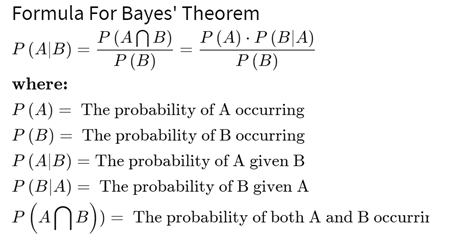

Strength:
- can handle small dataset
- Can handle both categorical and numerical data
- fast calculation

Weakness:
- Sensitive to outliers
- Feature independence may not be relevant based on model


## Model Without Tuning

In [44]:


pipe_model = Pipeline([
    ('transformer', transformer),
    ('dense',DenseTransformer()),
    ('model', naive_bayes)
])

pipe_model.fit(X_train,y_train)

y_pred = pipe_model.predict(X_test)

precision_before_tuning = precision_score(y_test,y_pred)
precision_before_tuning

0.7712264150943396

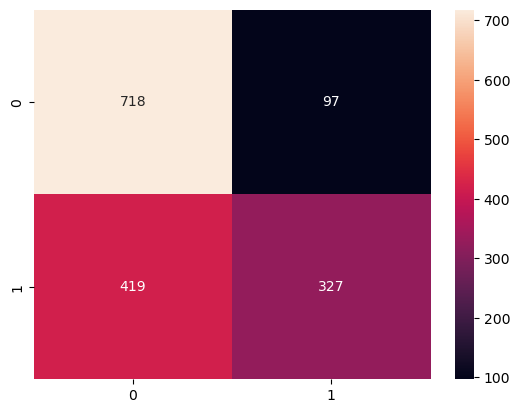

In [45]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');

In [46]:
print(f' Positive Rate is {round(327/(327+97)*100,2)}%')

 Positive Rate is 77.12%


In [47]:
print(f'Negative Rate is {round(419/(419+718)*100,2)}%')

Negative Rate is 36.85%


## Hyperparameter Tuning

In [48]:
transformer = ColumnTransformer([
    ('robust',RobustScaler(),['balance','campaign','pdays']),
    ('onehot',OneHotEncoder(drop='first'),['job','housing','loan','contact','month','poutcome','bin_age'])
],remainder='passthrough')

In [49]:
# untuk estimator
pipe_model = Pipeline([
    ('transformer', transformer),
    ('dense',DenseTransformer()),
    ('model', naive_bayes)
])

# untuk param_distributions
hyperparam_space = {
    'model__var_smoothing': list(np.arange(0,1,0.025)),
    'transformer__robust': [MinMaxScaler(), StandardScaler(), RobustScaler()],
}

# randomized search
gridsearch = GridSearchCV(
    estimator= pipe_model,
    param_grid= hyperparam_space,
    cv = 5,
    scoring= 'precision',
    n_jobs= -1,
    verbose=1,
    error_score='raise'
) 

In [50]:
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['balance',
                                                                          'campaign',
                                                                          'pdays']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['job',
                                                                          'housing',
                                           

In [51]:
gridsearch.best_score_

0.7840521052711156

In [52]:
gridsearch.best_params_

{'model__var_smoothing': 0.4, 'transformer__robust': MinMaxScaler()}

## Predict to Test Set

In [53]:
best_model = gridsearch.best_estimator_

best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)



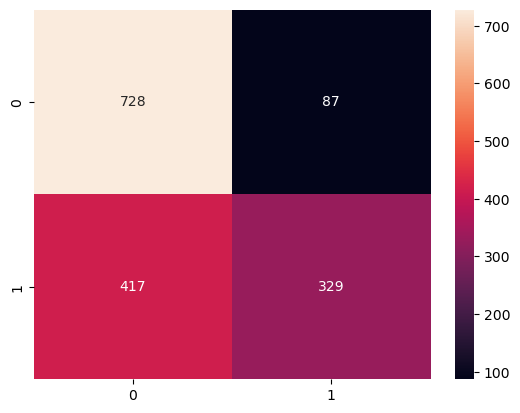

In [54]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g');

- 728 --> true negative (prediksi tidak deposit aktual tidak deposit)

- 87 --> false positive (prediksi deposit aktual tidak deposit )

- 417 --> false negative (prediksi tidak deposit aktual deposit)

- 329 --> true positive (prediksi deposit aktual deposit)

### Interpretation

- True positive predicton rate is 329 / (329 + 87) = 79 % --> Which means we can reach converted customer goal faster using this model instead of randomly picking from list (only 47% of entire customers will deposit from entire database)

- once we have contacted all of predicted deposited customers, we can move on towards predicted  negative customers. False negative rate is 417 / (417 + 728) = 36% --> Meaning there is 36% chance to get deposit customers picking randomly, 11% lower from before using model

In conclusion, we can reach customer goal earlier instead of hurrying to catch up at the end of quarter using this model.

## Cost Calculation

- Based on research,  cold calls should lasts 5 minutes and costs Rp 636/30s. So per call should cost Rp 10,600. But we only counts failed calls for sake of simplicity.
- Before this model, probability for customers to NOT deposit is 53%. So expected cost per call is : 53% x 10,600 = Rp 5,618
- After this model, probability for customers to NOT deposit is 21%. So expected cost per call for predicted positive group is :  21% x 10,600 = Rp 2,226

<br>

- Lets assume quarterly goal for deposit is 650
- before this model the expected cost would be 5,618 x 650 = Rp 3,651,700

<br>

- After this model, we contact predicted positive class so the cost would be : 2,226 x  416 (from entire predicted positive class) = Rp 926,016
- Then we proceed to get remaining customers (234 people) from negative predicted customers: 234 x (64% x 10,600) = Rp 1,587,456
- total cost after the model: 926,016 + 1,587,456 = Rp 2,513,472

<br>

- Our model saves 3,651,700 - 2,513,472 = Rp 1,138,228 or decrease spending by 31%

## Feature Importance

for feature importance, naive bayesian use function named mutual_info_classif.

mutual_info_classif calculates mutual information between each feature and target variable. Mutual information ranges from 0 to 1, where 0 means feature is independent and 1 is  perfectly correlated with target variable. Therefore, the higher the value means the more important the feature.

However, mutual information only captures relationship between single feature and target variable, and may not capture interactions between multiple features. 

In [55]:
from sklearn.feature_selection import mutual_info_classif


In [56]:
pipe_model = Pipeline([
    ('transformer', transformer),
    ('dense',DenseTransformer()),
])

X_train_new = pipe_model.fit_transform(X_train)

result_feat = mutual_info_classif(X_train_new, y_train,random_state=0)


In [57]:
df_importances = pd.DataFrame({
    'column': feature_names,
    'importance': result_feat})

df_importances.sort_values('importance',ascending=False).reset_index(drop=True)

,column,importance
0,x5_success,0.049781
1,x3_unknown,0.046153
2,pdays,0.038747
3,balance,0.036166
4,x1_yes,0.024452
5,x4_may,0.020722
6,campaign,0.015111
7,x4_oct,0.012820
8,x0_blue-collar,0.012640
9,x6_retiree,0.012505


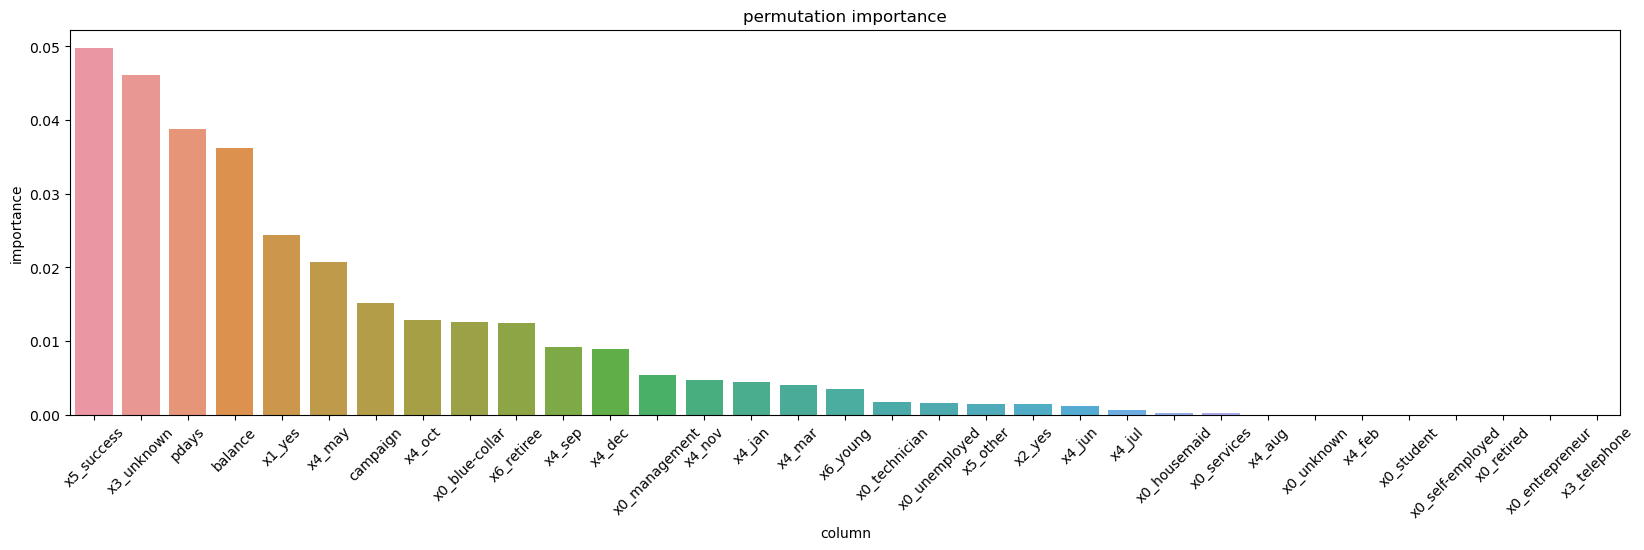

In [58]:
plt.figure(figsize=(20,5))

plt.title('permutation importance')
sns.barplot(data=df_importances.sort_values('importance',ascending=False),x='column',y='importance')
plt.xticks(rotation=45);

### Before and After Tuning

In [59]:
pd.DataFrame({
    'before tuning': [precision_before_tuning],
    'after tuning': [gridsearch.best_score_],
    'difference': [gridsearch.best_score_ - precision_before_tuning]
})

,before tuning,after tuning,difference
0,0.771226,0.784052,0.012826


# Kmeans

We use clustering method to identify audience tendencies based on age and balance. This can help develop focused strategy for each group

In [60]:
df_cluster = pd.read_csv('C:/Users/yyogi/OneDrive/Data Science Purwadhika/Catatan Modul 3 Machine Learning/Capstone Project Model 3/data_bank_marketing_campaign.csv')

df_cluster = df_cluster[['age','balance']]

df_cluster.head()

,age,balance
0,55,1662
1,39,-3058
2,51,3025
3,38,-87
4,36,205


In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [62]:
list_k = range(2,10)
list_sil = []

for k in list_k:

    kmeans = KMeans(n_clusters= k)
    kmeans.fit(df_cluster)

    cluster = kmeans.labels_
    sil = silhouette_score(df_cluster, cluster)
    list_sil.append(sil)

# --------------------------------
df_sil = pd.DataFrame({
    'k': list_k,
    'sil_score': list_sil
})

df_sil.sort_values('sil_score', ascending=False)

,k,sil_score
0,2,0.841558
1,3,0.772383
2,4,0.710465
3,5,0.709654
4,6,0.669674
5,7,0.636052
6,8,0.635333
7,9,0.613624


Based on age and balance, the best way to group the customers is into two groups

In [63]:
# define K-means
kmeans = KMeans(n_clusters=2, random_state=0)

# fit
kmeans.fit(df_cluster)

# memberi nama cluster
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
df_cluster['cluster'] = kmeans.labels_

df_cluster.head()

,age,balance,cluster
0,55,1662,0
1,39,-3058,0
2,51,3025,0
3,38,-87,0
4,36,205,0


In [65]:
df_cluster['cluster'] = np.where(df_cluster['cluster']==0,'A','B')


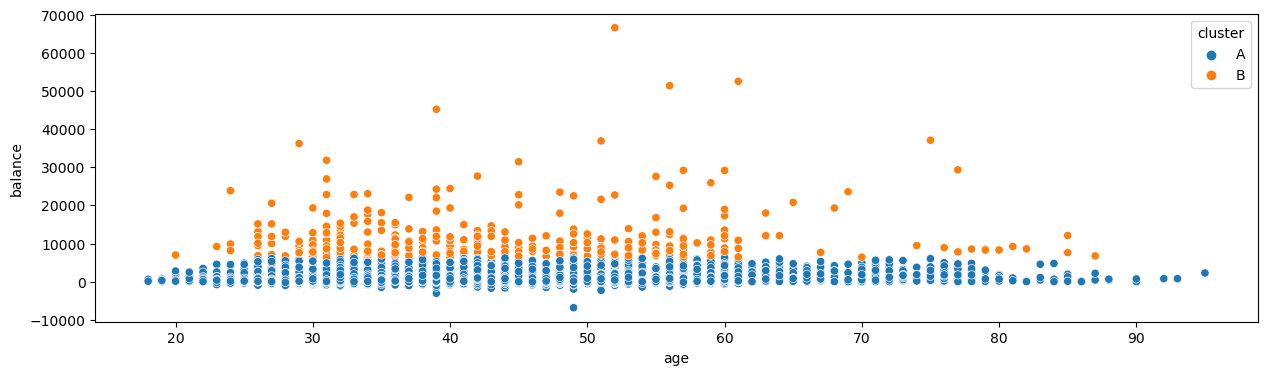

In [66]:
plt.figure(figsize=(15,4))
sns.scatterplot(data=df_cluster, x='age', y='balance', hue='cluster'); 

Based on the clustering result, we can conclude that there are 2 different groups in our database.


Group A is for people that has balance less than certain amount. We can categorize these group as less financially-savvy.


Possible strategy for this group are:

- emphasize of guaranteed return and safety. Because they are less likely to know much regarding finance.

- easy process to deposit. Because they feel safer if they understand the know-how.

- transparancy of deposited balance. Because they can be assurred their money is there.

Group B is for people that has balance more than certain amount. We can categorize these group as more financially-savvy.

Possible strategy for this group are:

- emphasize on interest rate higher than inflation. Since they are financially literate.
- safe from loss. To avoid loss instead of investing in stock or other financial choice.
- Personal approach since trust is key difference for people with more money

In [67]:
import pickle

In [68]:
best_model = gridsearch.best_estimator_

best_model.fit(X_train,y_train)

pickle.dump(best_model, open('C:/Users/yyogi/OneDrive/Data Science Purwadhika/Catatan Modul 3 Machine Learning/Capstone Project Model 3/Model_Bank_Deposit_Muhammad_Yogi_Ilham.sav','wb'))